### Housekeeping

In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
import datetime as dt
from tensorflow import keras
from Settings import columns, experiments
import Pipeline
import matplotlib.pyplot as plt
import keras_tuner as kt
# import PCA
import seaborn as sns
from sklearn.decomposition import PCA

%matplotlib notebook
%load_ext tensorboard

<IPython.core.display.Javascript object>


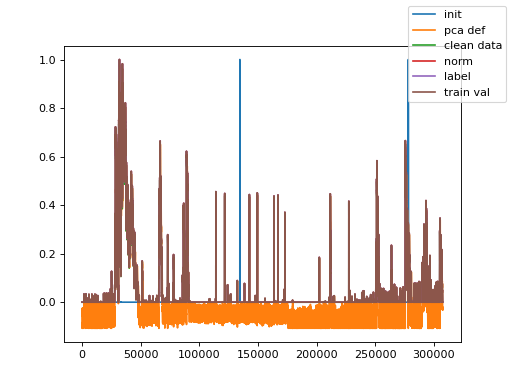

In [4]:
current_exp = experiments['pca1']

# pipeline = Pipeline.DataClean(columns, current_exp)
fig,ax = plt.subplots()

pipeline.data['reflection'].plot(label='init')
def pca(self):
    """ Applying PCA to specific columns """
    for cols, col_name in zip(self.exp['pca_cols'], self.exp['pca_col_names']):
        skpca = PCA(n_components=0.50)
        pca_xtrain = skpca.fit_transform(self.data[cols])
        self.data.loc[:,col_name] = pca_xtrain

# For some reason PCA within class is glitching
pca(pipeline)

pipeline.data['reflection'].plot(label='pca def')

pipeline.clean_data()
pipeline.data['reflection'].plot(label='clean data')

pipeline.norm()
pipeline.data['reflection'].plot(label='norm')

pipeline.split_label()
pipeline.data['reflection'].plot(label='label')

pipeline.train_val()  
pipeline.data['reflection'].plot(label='train val')

fig.legend()

## PCA

In [4]:
pipeline.floatdata.columns

Index(['Azimuth Angle [degrees]', 'Total Cloud Cover [%]',
       'Peak Wind Speed @ 6ft [m/s]', 'Avg Wind Direction @ 6ft [deg from N]',
       'Station Pressure [mBar]', 'Precipitation (Accumulated) [mm]',
       'radiance', 'temp', 'wetness', 'reflection'],
      dtype='object')

<IPython.core.display.Javascript object>


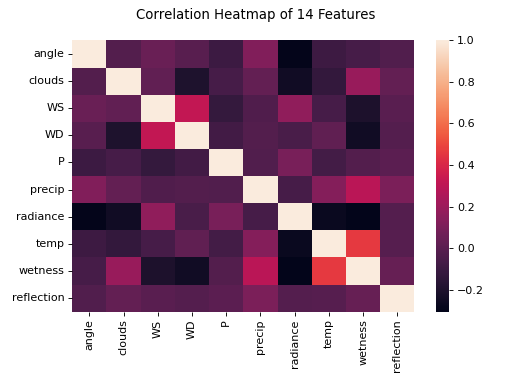

In [5]:
# srt_name = ['Irradiance','Wet Bulb', 'Radiation','Azimuth','Dew Point','RH','Cloud Cover','Max Wind','Avg Wind Deg','Pressure',
#            'Precip','Snow Depth','Moisture','Albedo']
srt_name = [col for col in columns if (col != 'IR')&(columns[col] in pipeline.floatdata.columns)]+current_exp['pca_col_names']
corr = pipeline.floatdata.corr()

cfig, cax = plt.subplots()
sns.heatmap(corr, ax=cax)
cax.set_xticklabels(srt_name)
cax.set_yticklabels(srt_name)
# plt.rcParams['figure.figsize'] = [7,7]
cfig.suptitle('Correlation Heatmap of 14 Features')
plt.tight_layout()

<IPython.core.display.Javascript object>


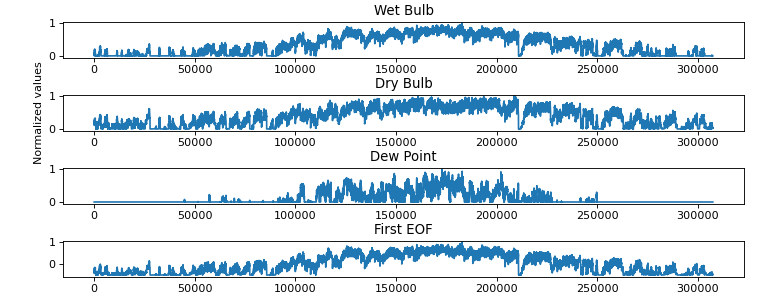

In [39]:
pcafig, pcaax = plt.subplots(nrows=4)
pcaax[0].plot(pipeline.data[columns['WB']])
pcaax[0].set_title('Wet Bulb')
pcaax[1].plot(pipeline.data[columns['DB']])
pcaax[1].set_title('Dry Bulb')
pcaax[2].plot(pipeline.data[columns['DP']])
pcaax[2].set_title('Dew Point')
pcaax[3].plot(lookatme[1])
pcaax[3].set_title('First EOF')
pcaax[1].set_ylabel('Normalized values')
plt.tight_layout()

<IPython.core.display.Javascript object>


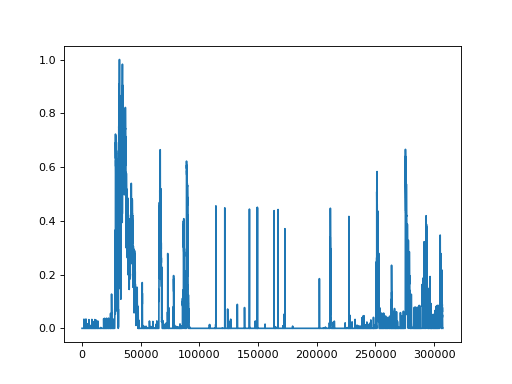

<AxesSubplot:>

In [11]:
fig,ax = plt.subplots()
pipeline.floatdata['reflection'].plot()

Look into just using environmental variable instead of using the previous persistence of solar IR

In [7]:
pipeline.floatcols

Index(['Global CMP22 (vent/cor) [W/m^2]', 'Direct sNIP [W/m^2]',
       'Azimuth Angle [degrees]', 'Tower Dry Bulb Temp [deg C]',
       'Tower Wet Bulb Temp [deg C]', 'Tower Dew Point Temp [deg C]',
       'Tower RH [%]', 'Total Cloud Cover [%]', 'Peak Wind Speed @ 6ft [m/s]',
       'Avg Wind Direction @ 6ft [deg from N]', 'Station Pressure [mBar]',
       'Precipitation (Accumulated) [mm]', 'Snow Depth [cm]', 'Moisture',
       'Albedo (CMP11)', 'radiance', 'temp', 'wetness', 'reflection'],
      dtype='object')

# Model Creation

#### Model Hyperparameters

In [13]:
# setting seed
# SEED = 26
SEED = 5428
# try:
#     tf.random.set_seed(SEED)
# except:
#     tf.set_random_seed(SEED)
SEED

5428

### Skeleton
Below is creating the "skeleton" of the model. It does not need any specific data, only the shape and what it will do

Using the functional API method

In [19]:
def create_model(pipeline, exp):
    # First we start with an input layer
    input_layer = keras.layers.Input(shape=(pipeline.xtrain[0].shape)) # size per sample, equal to number of features

    # Dropout may be useful for hidden layers if the number of hidden nodes is large
    # Let's apply dropout to the input layer. (If Dropout(0), Dropout isn't being used)
    layers = keras.layers.Dropout(exp['DROPOUT'])(input_layer)
    
    ACTIVATION = [exp['ACTIVATION']]*len(exp['HIDDENS'])
    
    for hidden,activation in zip(exp['HIDDENS'], ACTIVATION):
        layers = keras.layers.Dense(hidden, activation=activation)(layers) #,
#                        bias_initializer=tf.keras.initializers.RandomNormal(seed=SEED),
#                        kernel_initializer=tf.keras.initializers.RandomNormal(seed=SEED))(layers)

        layers = keras.layers.Dropout(exp['DROPOUT'])(layers)

    # Output layer has a softmax function to convert output to class likelihood
    output_layer = keras.layers.Dense(pipeline.ytrain[0].shape[0], activation='softmax')(layers) #,
#                       bias_initializer=tf.keras.initializers.RandomNormal(seed=SEED),
#                       kernel_initializer=tf.keras.initializers.RandomNormal(seed=SEED))(layers)


    model= keras.Model(input_layer, output_layer)
    
    return model

In [39]:
def create_model(pipeline, exp):
    model = keras.Sequential()
    model.add(keras.layers.Input(shape=(pipeline.xtrain[0].shape)))
    model.add(keras.layers.Dense(1320, activation='relu'))
    model.add(keras.layers.Dense(100, activation=exp['ACTIVATION']))
    model.add(keras.layers.Dense(pipeline.ytrain[0].shape[0], activation='relu'))
#     model.compile(optimizer=keras.optimizers.Adam(0.01), loss='mse',metrics=['mae'])
    
    return model

In [40]:
model = create_model(pipeline, current_exp)
model.summary()

Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_25 (Dense)            (None, 1320)              1585320   
                                                                 
 dense_26 (Dense)            (None, 100)               132100    
                                                                 
 dense_27 (Dense)            (None, 12)                1212      
                                                                 
Total params: 1,718,632
Trainable params: 1,718,632
Non-trainable params: 0
_________________________________________________________________


### Compile and Train the model

In [42]:
model.compile(optimizer=current_exp['optimizer'],
             loss=keras.losses.MeanSquaredError(),
             metrics=current_exp['metrics'])

log_dir = "logs/fit/" + dt.datetime.now().strftime("%Y%m%d-%H%M%S")
# callbacks ensures logs are created and stored
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1) 

history = model.fit(x=pipeline.xtrain, 
          y=pipeline.ytrain, 
          epochs=10,  #current_exp['NUM_EPOCH'], 
          validation_data=(pipeline.xval, pipeline.yval), 
          callbacks=[tensorboard_callback, current_exp['EARLY_STOPPING']])

Epoch 1/10
6720/6720 [==============================] - 87s 13ms/step - loss: 0.0028 - accuracy: 0.3687 - val_loss: 0.0063 - val_accuracy: 0.3804
Epoch 2/10
6720/6720 [==============================] - 83s 12ms/step - loss: 0.0027 - accuracy: 0.3648 - val_loss: 0.0067 - val_accuracy: 0.5198
Epoch 3/10
6720/6720 [==============================] - 86s 13ms/step - loss: 0.0026 - accuracy: 0.3579 - val_loss: 0.0058 - val_accuracy: 0.3414
Epoch 4/10
6720/6720 [==============================] - 84s 12ms/step - loss: 0.0025 - accuracy: 0.3524 - val_loss: 0.0059 - val_accuracy: 0.4244
Epoch 5/10
6720/6720 [==============================] - 84s 13ms/step - loss: 0.0024 - accuracy: 0.3467 - val_loss: 0.0053 - val_accuracy: 0.4180
Epoch 6/10
6720/6720 [==============================] - 88s 13ms/step - loss: 0.0024 - accuracy: 0.3413 - val_loss: 0.0057 - val_accuracy: 0.2784
Epoch 7/10
6720/6720 [==============================] - 85s 13ms/step - loss: 0.0023 - accuracy: 0.3379 - val_loss: 0.0057 -

<IPython.core.display.Javascript object>


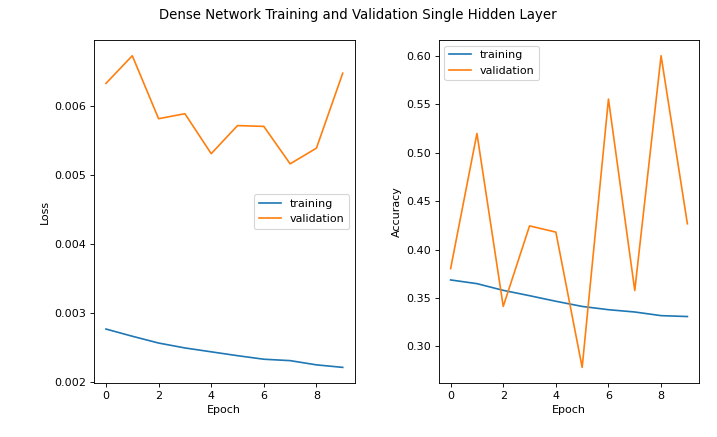

In [43]:
# Let's plot the change in loss and accuracy
fig, axs = plt.subplots(1, 2)

axs[0].plot(history.history['loss'], label='training')
axs[0].plot(history.history['val_loss'], label='validation')
axs[0].set_xlabel('Epoch')
axs[0].set_ylabel('Loss')
axs[0].legend()

axs[1].plot(history.history['accuracy'], label='training')
axs[1].plot(history.history['val_accuracy'], label='validation')
axs[1].set_xlabel('Epoch')
axs[1].set_ylabel('Accuracy')
axs[1].legend()
fig.suptitle('Dense Network Training and Validation Single Hidden Layer')
plt.tight_layout()

### Tensorboard

In [ ]:
%tensorboard --logdir logs/fit

## Predicting the Validation data

In [44]:
predict = model.predict(pipeline.xval)

<IPython.core.display.Javascript object>


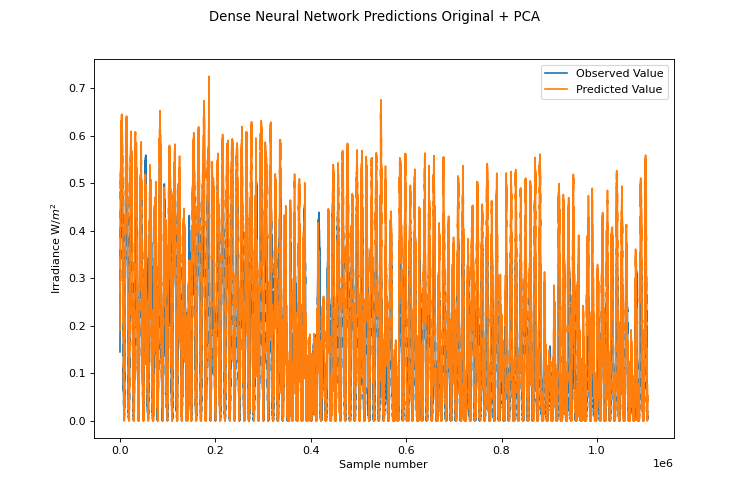

Text(0.5, 0, 'Sample number')

In [45]:
pfig, pax = plt.subplots()
pax.plot(pipeline.yval.reshape(-1), label='Observed Value')
pax.plot(predict.reshape(-1), label='Predicted Value')
pfig.suptitle('Dense Neural Network Predictions Original + PCA')
pax.legend()
pax.set_ylabel('Irradiance W/$m^2$')
pax.set_xlabel('Sample number')

In [22]:
np.corrcoef(predict, pipeline.yval)

MemoryError: Unable to allocate 253. GiB for an array with shape (184320, 184320) and data type float64

### Keras-Tuner

In [ ]:
def reshape(data):
    return data.reshape(-1, 120, len(pipeline.floatdata.columns))

xtrain = reshape(pipeline.xtrain)
# reshape(pipeline.ytrain)
xval = reshape(pipeline.xval)
# reshape(pipeline.yval)

In [ ]:
np.arange(32,512,150)

In [ ]:
def model_builder(hp):
   
    # defining a set of hyperparametrs for tuning and a range of values for each
    start_neurons = hp.Int(name = 'start_neurons', min_value = 16, max_value = 128, step = 16)
    net_depth = hp.Int(name = 'net_depth', min_value = 2, max_value = 6)
    dropout = hp.Boolean(name = 'dropout', default = False)
    bn_after_act = hp.Boolean(name = 'bn_after_act', default = False)
    activation = hp.Choice(name = 'activation', values = ['mish', 'elu', 'lrelu'], ordered = False)
    
    input_size = (544,544,3)
    target_labels = [str(i) for i in range(21)]
    
    # building a model
    model = u(input_size = input_size,
              start_neurons = start_neurons,
              net_depth = net_depth,
              output_classes = len(target_labels),
              dropout = dropout,
              bn_after_act = bn_after_act,
              activation = activation)
    
    # model compilation
    model.compile(optimizer = Adam(lr = 1e-3),
                  loss = weighted_cross_entropy,
                  metrics = [f1, precision, recall, iou])
    

  return model



# def model_builder(hp):
#     model = keras.Sequential()
#     model.add(keras.layers.Flatten(input_shape=(120,len(pipeline.floatdata.columns))))

#     # Tune the number of units in the first Dense layer
#     # Choose an optimal value between 32-512
#     hp_units = hp.Int('units', min_value=32, max_value=512, step=150)
#     model.add(keras.layers.Dense(units=hp_units, activation='relu'))
#     model.add(keras.layers.Dropout(current_exp['DROPOUT']))
    
#     hp_units1 = hp.Int('units', min_value=32, max_value=512, step=150)
#     model.add(keras.layers.Dense(units=hp_units1, activation='relu'))
#     model.add(keras.layers.Dropout(current_exp['DROPOUT']))
    
#     hp_units2 = hp.Int('units', min_value=32, max_value=512, step=150)
#     model.add(keras.layers.Dense(units=hp_units2, activation='relu'))
#     model.add(keras.layers.Dropout(current_exp['DROPOUT']))
    
#     model.add(keras.layers.Dense(12))

#     # Tune the learning rate for the optimizer
#     # Choose an optimal value from 0.01, 0.001, or 0.0001
#     hp_learning_rate = hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4])

#     model.compile(optimizer=keras.optimizers.Adam(learning_rate=hp_learning_rate),
#                 loss=keras.losses.MeanSquaredError(),
#                 metrics=['accuracy'])

#     return model







# model.add(keras.layers.Dense(units=hp_units, activation='relu',
#                                  bias_initializer=tf.keras.initializers.RandomNormal(seed=SEED),
#                                  kernel_initializer=tf.keras.initializers.RandomNormal(seed=SEED)))
#     model.add(keras.layers.Dropout(exp['DROPOUT']))
    
# #     hp_units = hp.Int('units', min_value=32, max_value=512, step=32)
#     model.add(keras.layers.Dense(units=hp_units, activation='relu',
#                                  bias_initializer=tf.keras.initializers.RandomNormal(seed=SEED),
#                                  kernel_initializer=tf.keras.initializers.RandomNormal(seed=SEED)))
#     model.add(keras.layers.Dropout(exp['DROPOUT']))

In [ ]:
tuner = kt.Hyperband(model_builder,
                     objective='val_accuracy',
                     max_epochs=10,
                     factor=3,
                     directory='my_dir',
                     project_name='intro_to_kt',
                     overwrite=True)

In [ ]:
stop_early = tf.keras.callbacks.EarlyStopping(monitor='val_loss',patience=5)

In [ ]:
tuner.search(xtrain, pipeline.ytrain, epochs=10, validation_data=(xval, pipeline.yval), callbacks=[stop_early])

In [ ]:
dir(tuner)
# tuner.results_summary()

In [ ]:
best_hps=tuner.get_best_hyperparameters(num_trials=1)[0]

In [ ]:
print(f"""
The hyperparameter search is complete. The optimal number of units in the first densely-connected
layer is {best_hps.get('units')} and the optimal learning rate for the optimizer
is {best_hps.get('learning_rate')}.
""")

In [ ]:
dir(tuner)
tuner.results_summary()

## Predicting the validation data